# Z1 Manipulator Arm

Trajectory Planning using varitop

## Imports

In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.integrator import DelIntegrator as DI
from varitop.opti import Varitop

In [3]:
import pinocchio as pin

In [4]:
import matplotlib.pyplot as plt
import casadi as cs
import numpy as np

In [5]:
from darli.model import Functional
from darli.backend import CasadiBackend

In [6]:
from mujoco_simulator.model_builder import ModelBuilder
from mujoco_simulator.simulator import MujocoRender

In [7]:
from robot_descriptions import z1_description

## Variational Integrator

Dynamics is specified as symbolical representation of the lagrangian of the model

In [8]:
z1_description.URDF_PATH

'/home/m8dotpie/.cache/robot_descriptions/unitree_ros/robots/z1_description/xacro/z1.urdf'

In [9]:
pinmodel, gpinmodel, cpinmodel = pin.buildModelsFromUrdf(z1_description.URDF_PATH, package_dirs='/home/m8dotpie/.cache/robot_descriptions/unitree_ros/robots', geometry_types=[pin.GeometryType.VISUAL, pin.GeometryType.COLLISION])

In [10]:
vis = pin.visualize.MeshcatVisualizer(pinmodel, gpinmodel, cpinmodel)

In [11]:
vis.initViewer(loadModel=True)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [12]:
darli_model = Functional(CasadiBackend(z1_description.URDF_PATH))
darli_model.add_body({'ee': 'link06'})

In [13]:
nq = darli_model.nq
nv = darli_model.nv
nu = darli_model.nu

In [14]:
di = DI(
    nq = nq,
    nu = nu,
    lagrangian = darli_model.lagrangian,
)

Actuation is added to the dynamics as a function of the control

In [15]:
di.add_force(di.u)

## Optimal Control Problem  

Time intervals (nodes):

In [16]:
ns = 150  # number of shooting nodes
tf = 1.5  # [s]
dt = tf/ns

Create problem instance, configuration and control variables:

In [17]:
vp = Varitop(
    integrator=di,
    nsteps=ns,
    dt=dt,
)

Create parametric initial and final points (joint and cartesian spaces):

In [18]:
initial_configuration = vp.parameter(6)
desired_pos = vp.parameter(3)

Set of constraints is specified:

1. Initial configuration is enforced
2. Initial velocity is zero
3. Final position of the end-effector, described symbolicaly is specified
4. Terminal velocity is zero

In [19]:
q = vp.q
u = vp.u

In [20]:
# initial point (joint space)
vp.subject_to(q[:, 0] == initial_configuration)
# vp.set_initial_configuration(initial_configuration)
vp.subject_to(q[:, 0] == q[:, 1])
# Terminal point (cartesian space)
vp.subject_to(darli_model.body('ee').position(q[:, -1]) == desired_pos)
vp.subject_to(q[:, -1] == q[:, -2])

Intermidiate costs are composed as such:

1. $10^{-2}|q|^2$
2. $5\cdot 10^{-2}\;|\dot{q}|^2$
3. $5 \cdot 10^{-3}\; |u|^2$
 
Terminal cost is defined as:

1. $5\cdot10^{-2}\;|q|^2$
2. $10^{-2}\;|\dot{q}|^2$

In [21]:
# cost
cost = 0 

# stage cost 
for i in range(ns-1):
    cost += 1e-2*cs.sumsqr(q[:, i])*dt
    cost += 5e-2*cs.sumsqr((q[:, i + 1] - q[:, i])/dt)*dt
    cost += 5e-3*cs.sumsqr(u[:, i])*dt
    
# Terminal cost 
cost += 5e-2*cs.sumsqr(q[:, -1])
cost += 10e-2*cs.sumsqr((q[:, -1] - q[:, -2])/dt)

vp.set_cost(cost)

Moreover, inequatlity constraints are introduced:

1. $v_{\text{min}} \leq v \leq v_{\text{max}}$
1. $u_{\text{min}} \leq u \leq u_{\text{max}}$

In [22]:
# Limits 
# joint limits 
vp.bounded(darli_model.q_min, q, darli_model.q_max)
# velocity limits
v_max = 1.5
qdot_lims = np.full((nv), v_max)
vp.bounded(-qdot_lims,(q[:, 1:] - q[:, :-1])/dt,  qdot_lims)
# torque limits
u_max = 5
u_lims = np.full((nu), u_max) 
vp.bounded(-u_max, u,  u_max)

Define numerical values for the parameters and solve:

In [23]:
vp.set_parameter(initial_configuration,np.zeros(6))
vp.set_parameter(desired_pos,[0.2, 0.2, 0.36])

In [24]:
sol = vp.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    17030
Number of nonzeros in inequality constraint Jacobian.:     3606
Number of nonzeros in Lagrangian Hessian.............:     9465

Total number of variables............................:     1806
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      915
Total number of inequality c

## Visualize

In [25]:
q_opt = vp.value(q)
u_opt = vp.value(u)
# q_opt

In [55]:
darli_model.body('ee').position(q_opt[:, -1]), vp.value(desired_pos)

(DM([0.2, 0.2, 0.36]), array([0.2 , 0.2 , 0.36]))

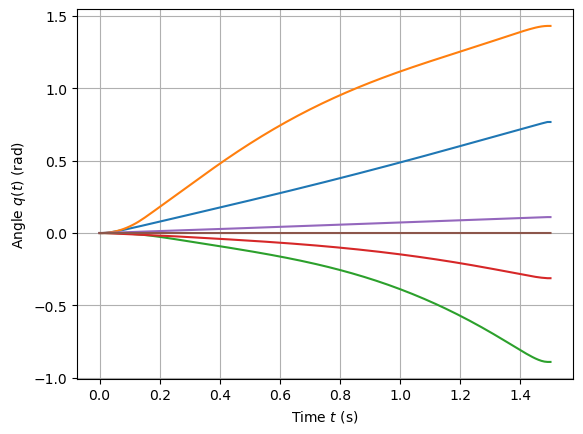

In [101]:
t = np.linspace(0, tf, ns+1)

# plt.title(r'Angles in joints')
plt.plot(t, q_opt.T)
plt.grid(True)
plt.ylabel(r'Angle $q(t)$ (rad)')
plt.xlabel(r'Time $t$ (s)')
plt.show()

In [104]:
u_opt.shape

(6, 150)

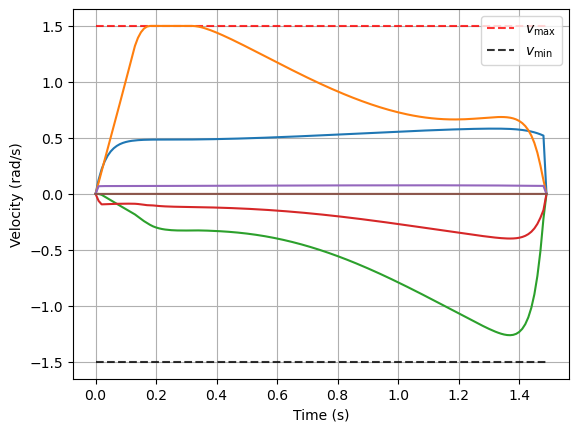

In [130]:
fig, ax = plt.subplots()

dq = np.diff(q_opt.T, axis=0) * ns / tf

ax.hlines(v_max, 0, tf-dt, color = 'red', linestyle = '--', alpha = 0.8,
          label='$v_{\\text{max}}$')
ax.hlines(-v_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8, label='$v_{\\text{min}}$')
ax.plot(t[:-1], dq)
ax.grid()
ax.legend()
ax.set_xlabel(
    'Time (s)'
)
ax.set_ylabel(
    'Velocity (rad/s)'
)
plt.savefig('velocities.png', dpi=300)
plt.show()

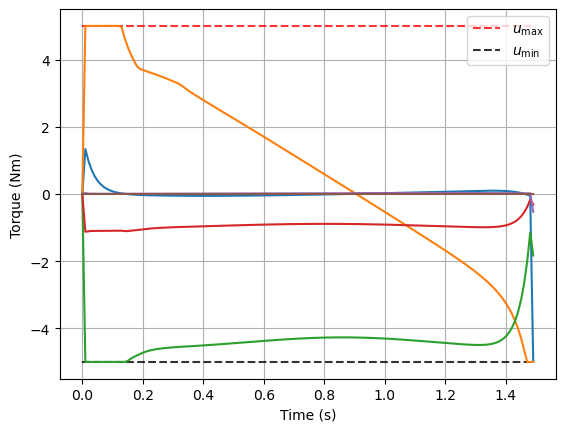

In [128]:
fig, ax = plt.subplots()
# plt.title(r'Torque in joints')
ax.hlines(u_max, 0, tf-dt, color = 'red', linestyle = '--', alpha = 0.8,
          label='$u_{\\text{max}}$')
ax.hlines(-u_max, 0, tf-dt, color = 'black', linestyle = '--', alpha = 0.8, label='$u_{\\text{min}}$')
ax.plot(t[:-1], u_opt.T)
ax.grid(True)
ax.legend()
ax.set_ylabel(r'Torque (Nm)')
ax.set_xlabel(r'Time (s)')
plt.savefig('torques.png', dpi=300)
plt.show()

In [68]:
ee_pos = []
for i in range(len(q_opt.T)):
    ee_pos.append(darli_model.body('ee').position(q_opt[:, i]).T)
ee_pos = np.array(ee_pos).squeeze()

In [73]:
dpos = np.array(vp.value(desired_pos))
pos0 = ee_pos[0, :]

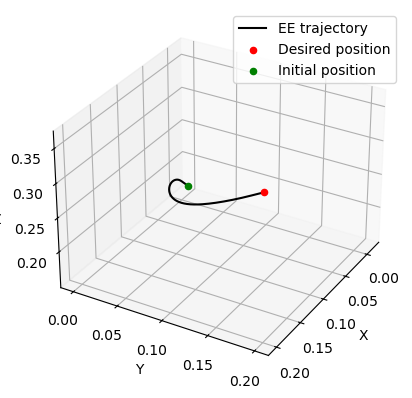

In [109]:
ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = ee_pos[:, 0]
y = ee_pos[:, 1]
z = ee_pos[:, 2]
ax.plot(x, y, z, label='EE trajectory', color='black')
ax.scatter(dpos[0], dpos[1], dpos[2], color='red', label='Desired position')
ax.scatter(pos0[0], pos0[1], pos0[2], color='green', label='Initial position')

# Make legend, set axes limits and labels
ax.legend()
# ax.set_xlim(0, 1)
# ax.set_ylim(0, 1)
# ax.set_zlim(0, 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=30., azim=30, roll=0)
plt.savefig('trajectory.png', dpi=300)
plt.show()

In [31]:
from time import sleep

In [32]:
for i in range(ns):
    vis.display(q_opt[:, i])
    sleep(0.2)

In [33]:
from PIL import Image
import io
import requests

In [34]:
# frames = []
# for i in np.linspace(0, ns-1, 4):
#     vis.display(q_opt[:, int(i)])
#     img = vis.captureImage()
#     frames.append(Image.fromarray(img))
# frames = np.array(frames)

In [35]:
# final_image = np.zeros_like(frames[0], dtype=float)
# for i in range(len(frames)):
#     if i == 0:
#         alpha = 1
#     elif i == len(frames) - 1:
#         alpha = 1
#     else:
#         alpha = 0.3
#     final_image += alpha * np.array(frames[i].astype(float))
#     final_image = np.clip(final_image, 0, 255)
# final_image = Image.fromarray(final_image.astype(np.uint8))
# final_image

In [36]:
cropped = final_image.crop((650, 150, 1250, 750))
cropped

NameError: name 'final_image' is not defined

In [ ]:
cropped.save('z1_blended.png')